In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import yfinance as yahooFinance
from docplex.mp.model import Model


from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage



def continuous_var_series(df, mdl,**kargs):
    return pd.Series(mdl.continuous_var_list(df.index, **kargs), index = df.index)

class CplexSum():
    """Function class that adds a series of dvars into a cplex sum expression.
    To be used as a custom aggregation in a groupby.
    Usage:
        df2 = df1.groupby(['a']).agg({'xDVar':CplexSum(engine.mdl)}).rename(columns={'xDVar':'expr'})

    Sums the dvars in the 'xDVar' column into an expression
    """
    def __init__(self, mdl):
        self.mdl = mdl
    def __call__(self, dvar_series):
        return self.mdl.sum(dvar_series)


def extract_solution(df, extract_dvar_names=None, drop_column_names=None, drop:bool=True):
    df = df.copy()
    """Generalized routine to extract a solution value. 
    Can remove the dvar column from the df to be able to have a clean df for export into scenario."""
    if extract_dvar_names is not None:
        for xDVarName in extract_dvar_names:
            if xDVarName in df.columns:
                df[f'{xDVarName}_Solution'] = [dvar.solution_value for dvar in df[xDVarName]]
                if drop:
                    df = df.drop([xDVarName], axis = 1)
    if drop and drop_column_names is not None:
        for column in drop_column_names:
            if column in df.columns:
                df = df.drop([column], axis = 1)
    return df  


def Quad(Q,x, model):
    n = Q.shape[0]
    return model.sum( Q[i,j] * x[i] * x[j] for i in range(0,n) for j in range(0,n))

# Fetch the Data

In [59]:
assets = ["AAPL", "MSFT","AMZN","GOOGL","META","NVDA","IBM","INTC", "ADBE","CSCO","HPQ","QCOM","TXN"]

initial_date = "2020-01-01"
today = datetime.today().strftime('%Y-%m-%d')

In [60]:
df_prices = pd.DataFrame()
for i in assets:

    GetInformation = yahooFinance.Ticker(i)
    u = GetInformation.history(start=initial_date, end=today, auto_adjust=True)[['Close']]
    u['return'] = u['Close'].pct_change()
    u = u.reset_index(drop = False)
    u['symbol'] = i
    df_prices = pd.concat([df_prices, u], axis = 0)

df_prices = df_prices[~pd.isnull(df_prices['return'])]

In [64]:
df_prices.to_csv("df_prices.csv")

symbol,AAPL,ADBE,AMZN,CSCO,GOOGL,HPQ,IBM,INTC,META,MSFT,NVDA,QCOM,TXN
Date,,,,,,,,,,,,,
2020-01-03 00:00:00-05:00,72.251137,331.809998,93.748497,41.725426,68.075996,17.867865,103.478966,53.350010,208.448837,152.295410,58.785030,79.024315,112.706062
2020-01-06 00:00:00-05:00,72.826851,333.709991,95.143997,41.874344,69.890503,17.937490,103.294098,53.199104,212.374680,152.689056,59.031540,78.561180,111.921471
2020-01-07 00:00:00-05:00,72.484344,333.390015,95.343002,41.602772,69.755501,17.981009,103.363403,52.311417,212.834183,151.296860,59.746223,80.795135,114.081284
2020-01-08 00:00:00-05:00,73.650345,337.869995,94.598503,41.629055,70.251999,18.215996,104.226105,52.346931,214.991898,153.706787,59.858265,80.559021,114.389816
2020-01-09 00:00:00-05:00,75.214737,340.450012,95.052498,41.453850,70.989502,18.485800,105.327629,52.639870,218.068634,155.627045,60.515675,81.648758,115.773857


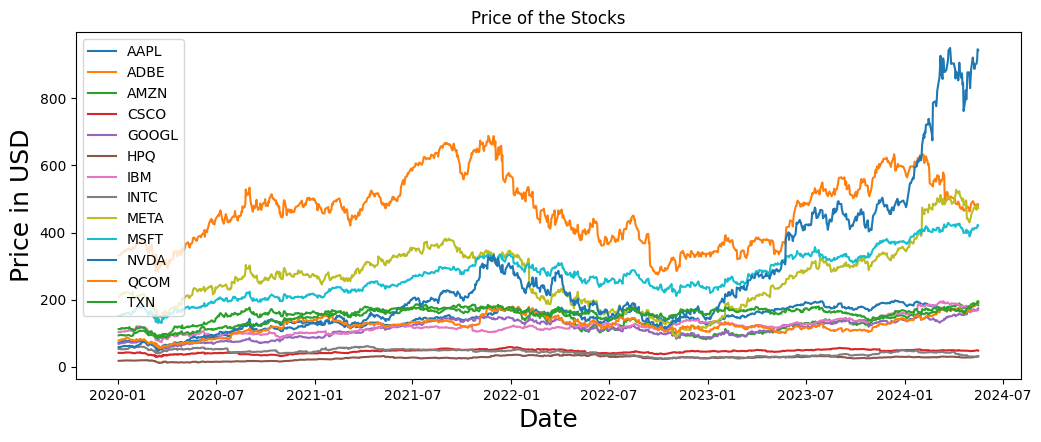

In [226]:
df = df_prices.pivot(columns = 'symbol',index = "Date" , values = 'Close' )
display(df.head())


plt.figure(figsize=(12.2,4.5)) 
for i in df.columns.values:
    plt.plot( df[i],  label=i)
plt.title('Price of the Stocks')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Price in USD',fontsize=18)
plt.legend(df.columns.values, loc='upper left')
plt.show()

In [227]:
mu = mean_historical_return(df)
S = CovarianceShrinkage(df).ledoit_wolf()

inputs = {}
inputs ['mean_return'] = pd.DataFrame(mu)
inputs ['Covariance'] = S


a=pd.DataFrame(mu, columns = ["mean_return"])
a["variance"]=S.values.diagonal()
a

,mean_return,variance
symbol,,
AAPL,0.247961,0.108052
ADBE,0.089844,0.152693
AMZN,0.166677,0.135640
CSCO,0.034317,0.080716
GOOGL,0.240381,0.111366
HPQ,0.135255,0.149459
IBM,0.119002,0.076136
INTC,-0.110405,0.170057
META,0.206833,0.217447


# Scenario 1: Maximize Return

In [243]:
# Model
mdl = Model("p1")

stocks = inputs ['mean_return']
stocks["X_proportion_invested"]= continuous_var_series(stocks, mdl, name="X_proportion_invested", lb = 0, ub = 1)
stocks.rename(columns = {0:"mu"}, inplace = True)
stocks

,mu,X_proportion_invested
symbol,,
AAPL,0.247961,X_proportion_invested_AAPL
ADBE,0.089844,X_proportion_invested_ADBE
AMZN,0.166677,X_proportion_invested_AMZN
CSCO,0.034317,X_proportion_invested_CSCO
GOOGL,0.240381,X_proportion_invested_GOOGL
HPQ,0.135255,X_proportion_invested_HPQ
IBM,0.119002,X_proportion_invested_IBM
INTC,-0.110405,X_proportion_invested_INTC
META,0.206833,X_proportion_invested_META


In [244]:
# Budget constraint: all investments sum up to 1
mdl.add_constraint (      mdl.sum(stocks["X_proportion_invested"])==1,  ctname ="Budget_Constraint");


# Limit on variance
V = 1
u = Quad ( inputs ['Covariance'].values , stocks['X_proportion_invested'].values, mdl)
Variance_constraint = mdl.add_constraint(u <= V, ctname="Variance")

# each security cannot exceed a certain percentage of the initial allocated wealth
for row in stocks.itertuples():
    mdl.add_constraint(row.X_proportion_invested <= 0.3)

In [245]:
# Define objective function: 


Variance = Quad(inputs ['Covariance'].values, stocks['X_proportion_invested'].values, mdl)
mdl.add_kpi(Variance   , "Variance")

#expected return
expected_return = mdl.sum( stocks['mu'] * stocks['X_proportion_invested'])
mdl.add_kpi(expected_return   , "expected_returns")

mdl.print_information()

Model: p1
 - number of variables: 13
   - binary=0, integer=0, continuous=13
 - number of constraints: 15
   - linear=14, quadratic=1
 - parameters: defaults
 - objective: none
 - problem type is: QCP


In [246]:
#Maximize expected return

mdl.maximize(expected_return)
mdl.solve(log_output= True)


Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
QCP Presolve eliminated 13 rows and 0 columns.
Reduced QCP has 28 rows, 27 columns, and 131 nonzeros.
Reduced QCP has 1 quadratic constraints.
Presolve time = 0.02 sec. (0.03 ticks)
Parallel mode: using up to 8 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 208
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.01 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 8
  Rows in Factor            = 28
  Integer space required    = 48
  Total non-zeros in factor = 301
  Total FP ops to factor    = 4459
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf Inf Ratio
   0   2.6437900e+00   0.0000000e+00  4.46e+01  0.00e+00  3.11e+01  2.64e+00
   1   7.3410707e-01   9.2440884e-02  4.46e+01  0.00e+00  3.11e+01  6.18e+00
   2   4.3381142e-01   4.1805352e-01  5.80e+00  

docplex.mp.solution.SolveSolution(obj=0.444148,values={X_proportion_inve..

In [248]:
mdl.report()

* model p1 solved with objective = 0.444
*  KPI: Variance         = 0.117
*  KPI: expected_returns = 0.444


In [250]:
result = extract_solution(stocks, extract_dvar_names=['X_proportion_invested']).reset_index(drop = False)
result["X_proportion_invested_Solution"] = result["X_proportion_invested_Solution"].round(3)
result


,symbol,mu,X_proportion_invested_Solution
0,AAPL,0.247961,0.3
1,ADBE,0.089844,0.0
2,AMZN,0.166677,0.0
3,CSCO,0.034317,0.0
4,GOOGL,0.240381,0.1
5,HPQ,0.135255,0.0
6,IBM,0.119002,0.0
7,INTC,-0.110405,0.0
8,META,0.206833,0.0
9,MSFT,0.262569,0.3


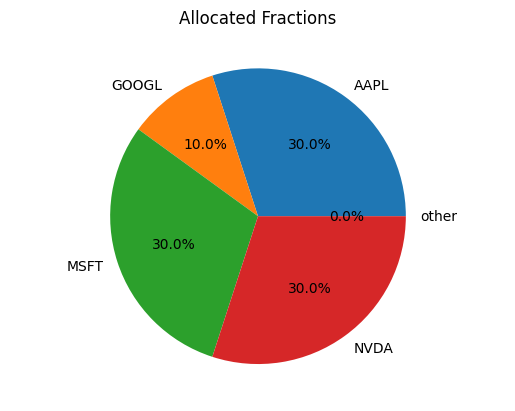

In [251]:
result_ = result.copy()
result_.loc[result_['X_proportion_invested_Solution'] < .05, 'symbol'] = 'other'
result_ = result_.groupby('symbol')['X_proportion_invested_Solution'].sum().reset_index()

plt.axis("equal")
plt.pie(result_['X_proportion_invested_Solution'], labels=result_['symbol'], autopct="%1.1f%%")
plt.title("Allocated Fractions")
plt.show()

# Scenario 2

- Minimize variance
- Semi-continous values for allocation: Either they should be zero or greater than a threshold

In [209]:
def semicontinuous_var_series(df, mdl,**kargs):
    return pd.Series(mdl.semicontinuous_var_list(df.index, **kargs), index = df.index)

In [210]:
# Model
mdl = Model("p2")

stocks = inputs ['mean_return']
stocks["X_proportion_invested"]= semicontinuous_var_series(stocks, mdl, name="X_proportion_invested", lb = .1, ub = 1)
stocks.rename(columns = {0:"mu"}, inplace = True)
stocks.head(2)

,mu,X_proportion_invested
symbol,,
AAPL,0.247961,X_proportion_invested_AAPL
ADBE,0.089844,X_proportion_invested_ADBE


In [211]:
# Budget constraint: all investments sum up to 1
mdl.add_constraint (      mdl.sum(stocks["X_proportion_invested"])==1,  ctname ="Budget_Constraint");


# each security cannot exceed a certain percentage of the initial allocated wealth (here 15%)
#for row in stocks.itertuples():
    #mdl.add_constraint(row.X_proportion_invested <= 0.2)


# Lower bound on expected return
mu_bar = 0.3  # Required return
return_constraints = mdl.add_constraint(mdl.sum( stocks['mu'] * stocks['X_proportion_invested']) >= mu_bar, ctname="Min_Return")

In [212]:
# Define objective function: 


Variance = Quad(inputs ['Covariance'].values, stocks['X_proportion_invested'].values, mdl)
mdl.add_kpi(Variance   , "Variance")

#expected return
expected_return = mdl.sum( stocks['mu'] * stocks['X_proportion_invested'])
mdl.add_kpi(expected_return   , "expected_returns")

mdl.minimize(Variance)

mdl.print_information()

Model: p2
 - number of variables: 13
   - binary=0, integer=0, continuous=0, semi-continuous=13
 - number of constraints: 2
   - linear=2
 - parameters: defaults
 - objective: minimize quadratic
 - problem type is: MIQP


In [213]:
#Minimize variance


mdl.solve()
mdl.report()

* model p2 solved with objective = 0.070
*  KPI: Variance         = 0.070
*  KPI: expected_returns = 0.300


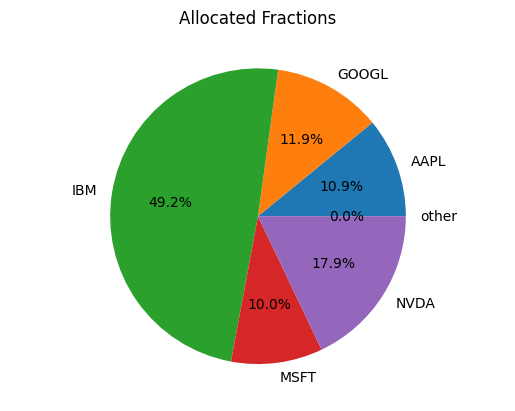

In [214]:
result = extract_solution(stocks, extract_dvar_names=['X_proportion_invested']).reset_index(drop = False)
result["X_proportion_invested_Solution"] = result["X_proportion_invested_Solution"].round(3)

result_ = result.copy()
result_.loc[result_['X_proportion_invested_Solution'] < .05, 'symbol'] = 'other'
result_ = result_.groupby('symbol')['X_proportion_invested_Solution'].sum().reset_index()

plt.axis("equal")
plt.pie(result_['X_proportion_invested_Solution'], labels=result_['symbol'], autopct="%1.1f%%")
plt.title("Allocated Fractions")
plt.show()

In [215]:
target_returns = np.linspace(0.1,1,10)
variances = []
for target in target_returns:
    print(target)
    # modify the constraint's right hand side.
    return_constraints.rhs = target
    cur_s = mdl.solve()
    assert cur_s  # solve is OK
    cur_variance = mdl.solution.kpi_value_by_name("Variance")
    print('- for a target return of: {0}%, variance={1}'.format(target, cur_variance))
    variances.append(cur_variance)

0.1
- for a target return of: 0.1%, variance=0.07004935765017872
0.2
- for a target return of: 0.2%, variance=0.07004935765017872
0.30000000000000004
- for a target return of: 0.30000000000000004%, variance=0.07004935765017872
0.4
- for a target return of: 0.4%, variance=0.08832293950659315
0.5
- for a target return of: 0.5%, variance=0.11581901907174275
0.6
- for a target return of: 0.6%, variance=0.14464680160662963
0.7000000000000001
- for a target return of: 0.7000000000000001%, variance=0.18585567421764837
0.8
- for a target return of: 0.8%, variance=0.23634696566864072
0.9


AssertionError: 

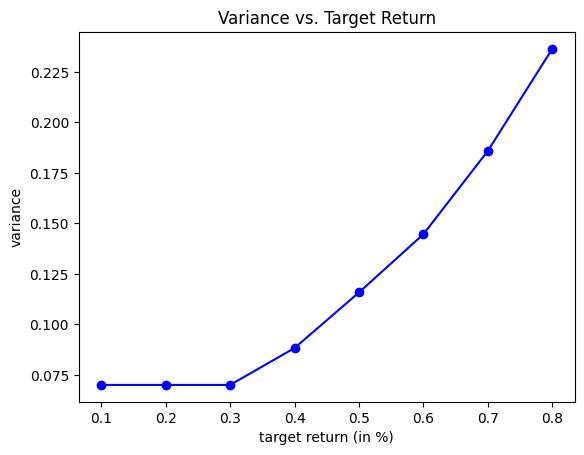

In [216]:
plt.plot(target_returns[0:len(variances)], variances, 'bo-')
plt.title('Variance vs. Target Return')
plt.xlabel('target return (in %)')
plt.ylabel('variance')
plt.show()